In [1]:
# matplotlib notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os

In [3]:
datadir = os.getcwd()
plotdir = datadir + '\\images\\'

In [4]:
cpus = ['DefaultO3']
bps = ['LTAGE']
sims = ['gem5-19','gem5-20']
archs = ['X86','RISCV']
mems = ['Slow']
bms = ['CCa','CCm','CCe','CCh','CCh_st','CCl','CF1','CRd','CRf','CRm','CS1','CS3',
       'DP1d','DP1f','DPcvt','DPT','DPTd','ED1','EF','EI','EM1','EM5','MD','MC','MCS',
       'M_Dyn','MI','MIM','MIM2','MIP','ML2','ML2_BW_ld','ML2_BW_ldst','ML2_BW_st','ML2_st',
       'MM','MM_st','STc','STL2','STL2b']
control = ['CCa','CCm','CCe','CCh','CCh_st','CCl','CF1','CRd','CRf','CRm','CS1','CS3']
exe = ['DP1d','DP1f','DPcvt','DPT','DPTd','ED1','EF','EI','EM1','EM5']
memory = ['MD','MC','MCS','M_Dyn','MI','MIM','MIM2','MIP','ML2','ML2_BW_ld','ML2_BW_ldst',
          'ML2_BW_st','ML2_st','MM','MM_st','STc','STL2','STL2b']

In [5]:
# function to extract stats
def gem5GetStat(filename, stat):
    filename = os.path.join(datadir, '', filename, 'stats.txt').replace('\\','/')
    with open(filename) as f:
        r = f.read()
        if len(r) < 10: return 0.0
        start = r.find(stat) + len(stat) + 1
        end = r.find('#', start)
        return float(r[start:end])

In [6]:
# data frame for TimingSimpleCPU
rows = []
for sim in sims:
    for arch in archs:
        for bp in bps:
            for cpu in cpus:
                for mem in mems:
                    for bm in bms:
                        cdir = datadir + '\\' + sim + '\\' + arch + '\\' + bp + '\\' + cpu + '\\' + mem + '\\' + bm + '\\'
                        rows.append([sim, arch, bp, cpu, mem, bm, 
                                     gem5GetStat(cdir, 'sim_insts'),
                                     gem5GetStat(cdir, 'sim_ticks')/1e12,
                                     gem5GetStat(cdir, 'system.cpu.commit.branchMispredicts'),
                                     gem5GetStat(cdir, 'system.cpu.commit.branches'),
                                     gem5GetStat(cdir, 'system.cpu.branchPred.BTBLookups'),
                                     gem5GetStat(cdir, 'system.cpu.branchPred.RASInCorrect'),      # Number of incorrect RAS predictions.
                                     gem5GetStat(cdir, 'system.cpu.branchPred.usedRAS'),           # Number of times the RAS was used to get a target
                                     gem5GetStat(cdir, 'system.cpu.branchPred.condIncorrect'),
                                     gem5GetStat(cdir, 'system.cpu.branchPred.condPredicted'),
                                     gem5GetStat(cdir, 'system.cpu.branchPred.indirectHits'),
                                     gem5GetStat(cdir, 'system.cpu.branchPred.indirectLookups'),
                                     gem5GetStat(cdir, 'system.cpu.branchPred.indirectMisses'),
                                     gem5GetStat(cdir, 'system.cpu.branchPredindirectMispredicted'),
                                     gem5GetStat(cdir, 'system.cpu.ipc'),
                                     gem5GetStat(cdir, 'system.cpu.l1d.overall_miss_rate::total'),
                                     gem5GetStat(cdir, 'system.cpu.l1i.overall_miss_rate::total'),
                                     gem5GetStat(cdir, 'system.l2cache.overall_miss_rate::total')])
                        
                
df_Simple = pd.DataFrame(rows, columns=['sim', 'arch', 'bp', 'cpu', 'mem', 'benchmark', 'instructions', 'sim_time', 'BranchMispredicted',
                                         'noOfBranches', 'BTBLookups','RASInCorrect', 'RASused', 'condIncorrect', 
                                         'condPredicted', 'indirectHits', 'indirectLookups','indirectMisses', 
                                        'indirectMispredicted','ipc', 'dcache_missrate','icache_missrate','l2_missrate'])

df_Simple['condMissRate'] = (df_Simple['condIncorrect']/df_Simple['condPredicted'])*100
df_Simple['noOfUncond'] = (df_Simple['noOfBranches'] - df_Simple['condPredicted'])
df_Simple['indirectMissRate'] = (df_Simple['indirectMispredicted']/df_Simple['indirectHits'])*100
df_Simple['branchMissRate'] = ((df_Simple['BranchMispredicted'])/(df_Simple['noOfBranches']))*100
df_Simple['noOfDirectBranches'] = ((df_Simple['BTBLookups']) - (df_Simple['indirectLookups']))

In [7]:
def plot_bar(sims, arch, cpu, bp, mem, benchmarks, stat, norm=True):
    plt.figure()
    i = 0
    for bm in benchmarks:
        for j,sim in enumerate(sims):
            if norm: 
                base = df_Simple[(df_Simple['data_size']==size)][stat].iloc[0]
            else: base = 1
            a = df_Simple[(df_Simple['sim']==sim) & (df_Simple['arch']==arch) & (df_Simple['bp']==bp)
                           & (df_Simple['cpu']==cpu) & (df_Simple['mem']==mem) & (df_Simple['benchmark']==bm)]
            plt.bar(i, a[stat].iloc[0]/base, color='C'+str(j))
            i += 1
        i += 1

    i = 0
    for i,sim in enumerate(sims):
        plt.bar(0,0,color='C'+str(i), label=sim)
        plt.xticks(np.arange(len(benchmarks))*(len(sims)+1)+i/2, benchmarks, rotation=40, ha='right')

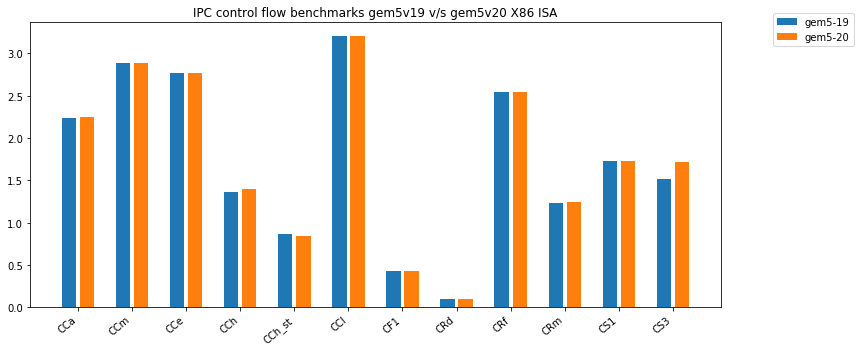

In [19]:
mem = 'Slow'
cpu = 'DefaultO3'
benchmarks = control
bp = 'LTAGE'
stat = 'ipc'
arch = 'X86'
plot_title = 'IPC control flow benchmarks gem5v19 v/s gem5v20 X86 ISA'
ylabel = ''

# plot function
plot_bar(sims, arch, cpu, bp, mem, benchmarks, stat, norm=False)

# plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 5 
plt.rcParams["figure.figsize"] = fig_size

plt.ylabel(ylabel)
plt.title(plot_title)

# plot directory

plt.legend(bbox_to_anchor=(1.2, 1.05))

plt.tight_layout()
# plt.savefig(plotdir + stat + '_timingSimple' + '.png', format='png', dpi=600)

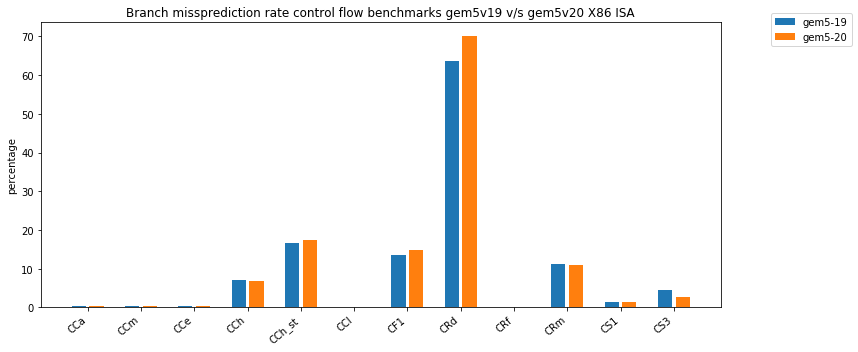

In [9]:
mem = 'Slow'
cpu = 'DefaultO3'
benchmarks = control
bp = 'LTAGE'
stat = 'branchMissRate'
arch = 'X86'
plot_title = 'Branch missprediction rate control flow benchmarks gem5v19 v/s gem5v20 X86 ISA'
ylabel = 'percentage'

# plot function
plot_bar(sims, arch, cpu, bp, mem, benchmarks, stat, norm=False)

# plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 5 
plt.rcParams["figure.figsize"] = fig_size

plt.ylabel(ylabel)
plt.title(plot_title)

# plot directory

plt.legend(bbox_to_anchor=(1.2, 1.05))

plt.tight_layout()
# plt.savefig(plotdir + stat + '_timingSimple' + '.png', format='png', dpi=600)

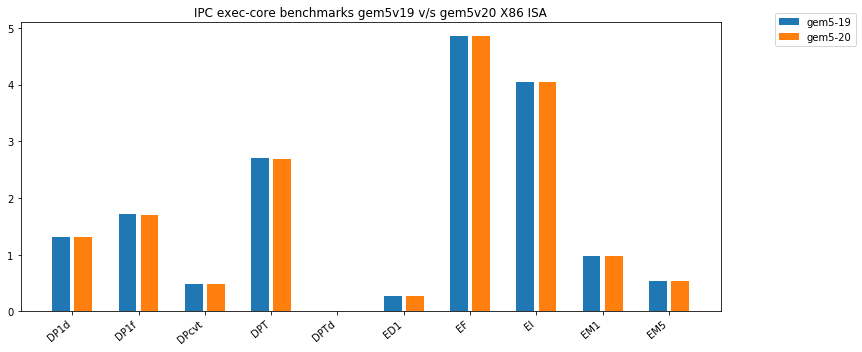

In [10]:
mem = 'Slow'
cpu = 'DefaultO3'
benchmarks = exe
bp = 'LTAGE'
stat = 'ipc'
arch = 'X86'
plot_title = 'IPC exec-core benchmarks gem5v19 v/s gem5v20 X86 ISA'
ylabel = ''

# plot function
plot_bar(sims, arch, cpu, bp, mem, benchmarks, stat, norm=False)

# plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 5 
plt.rcParams["figure.figsize"] = fig_size

plt.ylabel(ylabel)
plt.title(plot_title)

# plot directory

plt.legend(bbox_to_anchor=(1.2, 1.05))

plt.tight_layout()
# plt.savefig(plotdir + stat + '_timingSimple' + '.png', format='png', dpi=600)

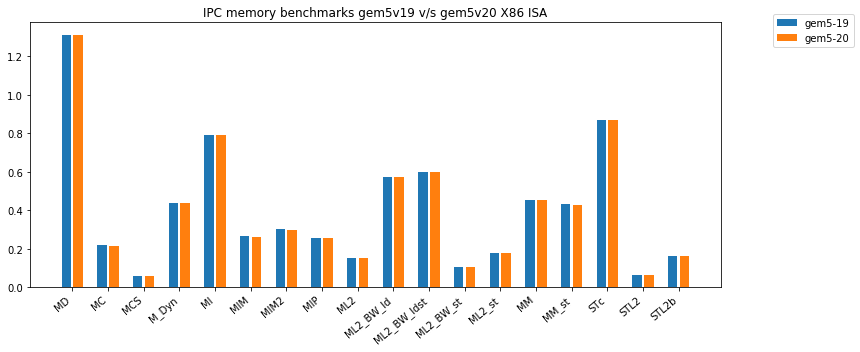

In [11]:
mem = 'Slow'
cpu = 'DefaultO3'
benchmarks = memory
bp = 'LTAGE'
stat = 'ipc'
arch = 'X86'
plot_title = 'IPC memory benchmarks gem5v19 v/s gem5v20 X86 ISA'
ylabel = ''

# plot function
plot_bar(sims, arch, cpu, bp, mem, benchmarks, stat, norm=False)

# plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 5 
plt.rcParams["figure.figsize"] = fig_size

plt.ylabel(ylabel)
plt.title(plot_title)

# plot directory

plt.legend(bbox_to_anchor=(1.2, 1.05))

plt.tight_layout()
# plt.savefig(plotdir + stat + '_timingSimple' + '.png', format='png', dpi=600)

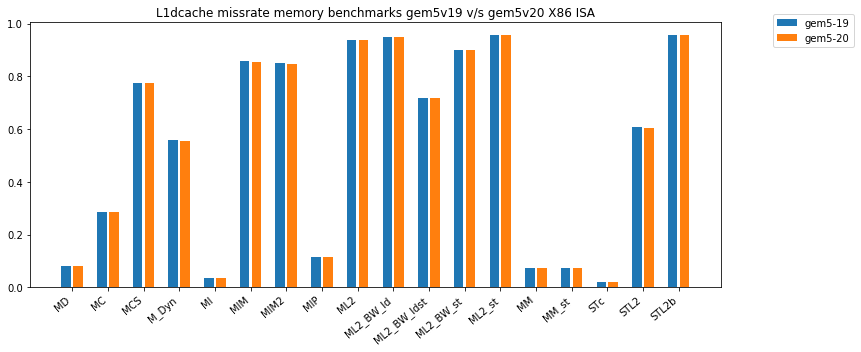

In [12]:
mem = 'Slow'
cpu = 'DefaultO3'
benchmarks = memory
bp = 'LTAGE'
stat = 'dcache_missrate'
plot_title = 'L1dcache missrate memory benchmarks gem5v19 v/s gem5v20 X86 ISA'
ylabel = ''

# plot function
plot_bar(sims, arch, cpu, bp, mem, benchmarks, stat, norm=False)

# plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 5 
plt.rcParams["figure.figsize"] = fig_size

plt.ylabel(ylabel)
plt.title(plot_title)

# plot directory

plt.legend(bbox_to_anchor=(1.2, 1.05))

plt.tight_layout()
# plt.savefig(plotdir + stat + '_timingSimple' + '.png', format='png', dpi=600)

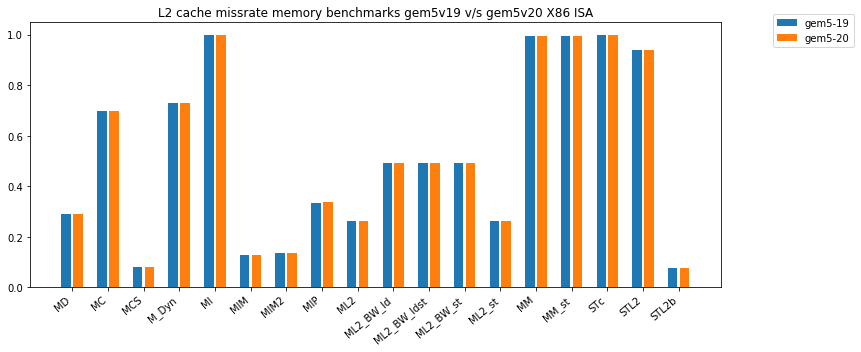

In [13]:
mem = 'Slow'
cpu = 'DefaultO3'
benchmarks = memory
bp = 'LTAGE'
stat = 'l2_missrate'
plot_title = 'L2 cache missrate memory benchmarks gem5v19 v/s gem5v20 X86 ISA'
ylabel = ''

# plot function
plot_bar(sims, arch, cpu, bp, mem, benchmarks, stat, norm=False)

# plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 5 
plt.rcParams["figure.figsize"] = fig_size

plt.ylabel(ylabel)
plt.title(plot_title)

# plot directory

plt.legend(bbox_to_anchor=(1.2, 1.05))

plt.tight_layout()
# plt.savefig(plotdir + stat + '_timingSimple' + '.png', format='png', dpi=600)

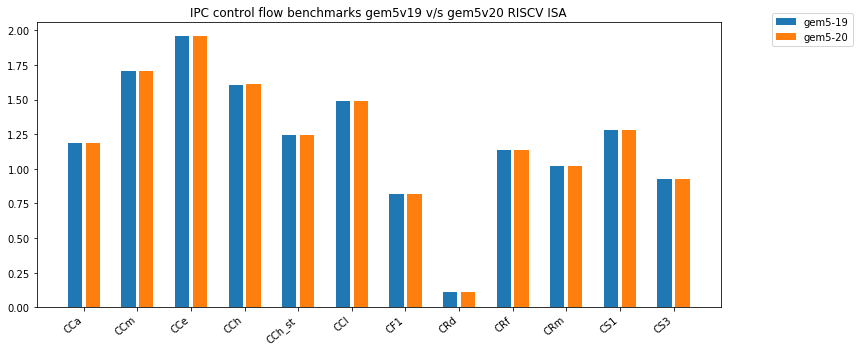

In [14]:
mem = 'Slow'
cpu = 'DefaultO3'
benchmarks = control
bp = 'LTAGE'
stat = 'ipc'
arch = 'RISCV'
plot_title = 'IPC control flow benchmarks gem5v19 v/s gem5v20 RISCV ISA'
ylabel = ''

# plot function
plot_bar(sims, arch, cpu, bp, mem, benchmarks, stat, norm=False)

# plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 5 
plt.rcParams["figure.figsize"] = fig_size

plt.ylabel(ylabel)
plt.title(plot_title)

# plot directory

plt.legend(bbox_to_anchor=(1.2, 1.05))

plt.tight_layout()
# plt.savefig(plotdir + stat + '_timingSimple' + '.png', format='png', dpi=600)

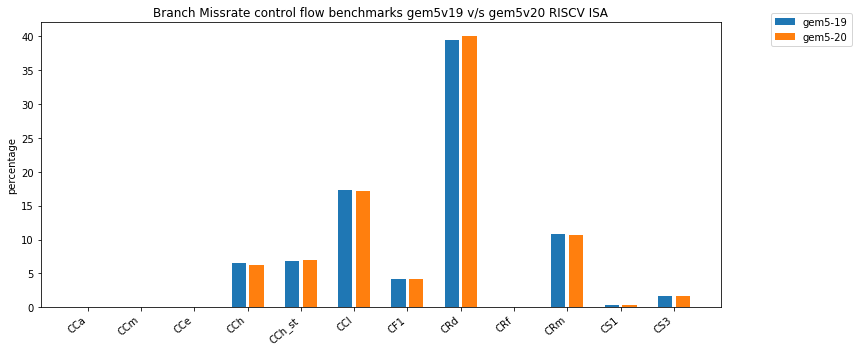

In [15]:
mem = 'Slow'
cpu = 'DefaultO3'
benchmarks = control
bp = 'LTAGE'
stat = 'branchMissRate'
arch = 'RISCV'
plot_title = 'Branch Missrate control flow benchmarks gem5v19 v/s gem5v20 RISCV ISA'
ylabel = 'percentage'

# plot function
plot_bar(sims, arch, cpu, bp, mem, benchmarks, stat, norm=False)

# plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 5 
plt.rcParams["figure.figsize"] = fig_size

plt.ylabel(ylabel)
plt.title(plot_title)

# plot directory

plt.legend(bbox_to_anchor=(1.2, 1.05))

plt.tight_layout()
# plt.savefig(plotdir + stat + '_timingSimple' + '.png', format='png', dpi=600)

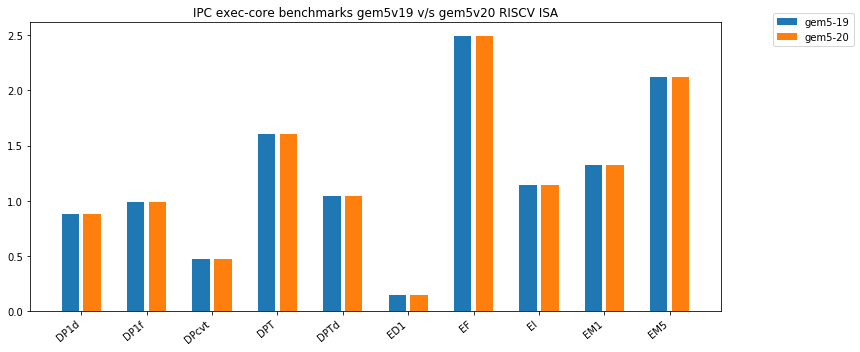

In [16]:
mem = 'Slow'
cpu = 'DefaultO3'
benchmarks = exe
bp = 'LTAGE'
stat = 'ipc'
arch = 'RISCV'
plot_title = 'IPC exec-core benchmarks gem5v19 v/s gem5v20 RISCV ISA'
ylabel = ''

# plot function
plot_bar(sims, arch, cpu, bp, mem, benchmarks, stat, norm=False)

# plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 5 
plt.rcParams["figure.figsize"] = fig_size

plt.ylabel(ylabel)
plt.title(plot_title)

# plot directory

plt.legend(bbox_to_anchor=(1.2, 1.05))

plt.tight_layout()
# plt.savefig(plotdir + stat + '_timingSimple' + '.png', format='png', dpi=600)

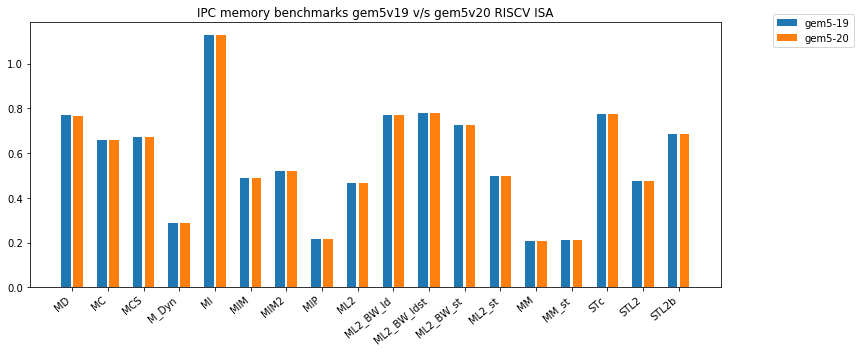

In [17]:
mem = 'Slow'
cpu = 'DefaultO3'
benchmarks = memory
bp = 'LTAGE'
stat = 'ipc'
arch = 'RISCV'
plot_title = 'IPC memory benchmarks gem5v19 v/s gem5v20 RISCV ISA'
ylabel = ''

# plot function
plot_bar(sims, arch, cpu, bp, mem, benchmarks, stat, norm=False)

# plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 5 
plt.rcParams["figure.figsize"] = fig_size

plt.ylabel(ylabel)
plt.title(plot_title)

# plot directory

plt.legend(bbox_to_anchor=(1.2, 1.05))

plt.tight_layout()
# plt.savefig(plotdir + stat + '_timingSimple' + '.png', format='png', dpi=600)

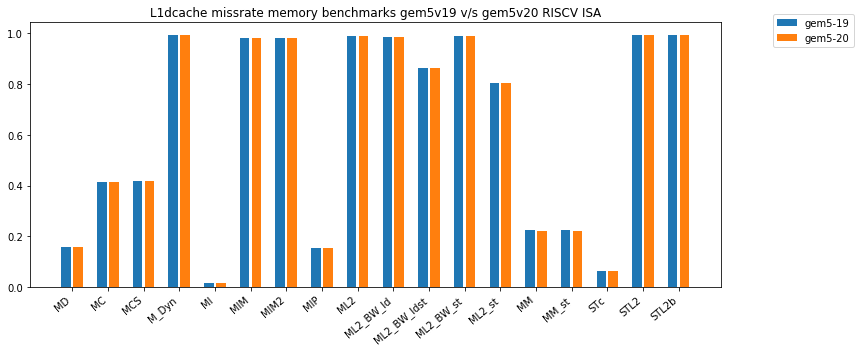

In [18]:
mem = 'Slow'
cpu = 'DefaultO3'
benchmarks = memory
bp = 'LTAGE'
stat = 'dcache_missrate'
arch = 'RISCV'
plot_title = 'L1dcache missrate memory benchmarks gem5v19 v/s gem5v20 RISCV ISA'
ylabel = ''

# plot function
plot_bar(sims, arch, cpu, bp, mem, benchmarks, stat, norm=False)

# plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 5 
plt.rcParams["figure.figsize"] = fig_size

plt.ylabel(ylabel)
plt.title(plot_title)

# plot directory

plt.legend(bbox_to_anchor=(1.2, 1.05))

plt.tight_layout()
# plt.savefig(plotdir + stat + '_timingSimple' + '.png', format='png', dpi=600)